## Московские ворота, Московский район

In [1]:
import os
import networkx as nx
import osmnx as ox
import geopandas as gpd

In [2]:
ox_crs = 4326
local_crs = 32636
example_data_path = './data'

city_geometry = gpd.read_file(os.path.join(example_data_path, "etalon_moskovskiy.geojson")).to_crs(ox_crs)

In [3]:
from masterplan_tools.preprocessing import GraphGenerator
intermodal_graph = GraphGenerator(city_geometry=city_geometry, local_crs=local_crs).get_graph()

In [4]:
blocks = gpd.read_parquet(os.path.join(example_data_path, "etalon_blocks.parquet")).to_crs(local_crs)
blocks = blocks.sjoin(city_geometry.to_crs(local_crs))

In [5]:
from masterplan_tools.preprocessing import DataGetter, AggregateParameters
dg = DataGetter(blocks=blocks)

In [6]:
accessibility_matrix = dg.get_accessibility_matrix(intermodal_graph)

In [7]:
import math

buildings = gpd.read_file(os.path.join(example_data_path, "etalon_buildings_moskovskiy.geojson")).to_crs(local_crs)
greenings = gpd.read_parquet(os.path.join(example_data_path, "greenings.parquet")).rename_geometry('geometry').to_crs(local_crs)
parkings = gpd.read_parquet(os.path.join(example_data_path, "parkings.parquet")).rename_geometry('geometry').to_crs(local_crs)

buildings.drop(labels=['name', 'address', 'municipality', 'ukname'], axis=1, inplace=True)
buildings['living_area_pyatno'] = 0
buildings['total_area'] = 0
buildings['storeys_count'] = 0
buildings['population_balanced'] = buildings['population_balanced'].fillna(0).apply(math.ceil)
buildings['is_living'] = buildings['population_balanced']>0

aggr_params = AggregateParameters(
  buildings=buildings,
  greenings=greenings,
  parkings=parkings
)
aggregated_blocks = dg.aggregate_blocks_info(aggr_params)

Restoring living area:   0%|          | 0/1557 [00:00<?, ?it/s]

Restoring living area squash:   0%|          | 0/1557 [00:00<?, ?it/s]

In [8]:
from masterplan_tools.models import City

city_model = City(accessibility_matrix.df, aggregated_blocks.to_gdf())

In [9]:
schools = gpd.read_file(os.path.join(example_data_path, "etalon_schools.geojson")).to_crs(local_crs)
kindergartens = gpd.read_file(os.path.join(example_data_path, "etalon_kindergartens.geojson")).to_crs(local_crs)
kindergartens.loc[kindergartens['id'] == 146055,'capacity'] = 0

city_model.update_service_type_layer(city_model['schools'], schools)
city_model.update_service_type_layer(city_model['kindergartens'], kindergartens)

In [10]:
from masterplan_tools.method.provision import Provision

selected_block = city_model[376]
provision = Provision(city_model=city_model)

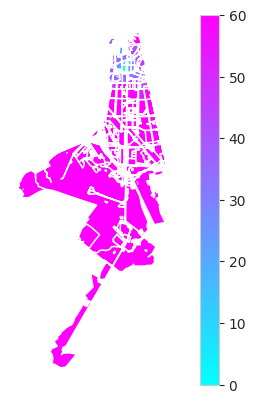

In [11]:
from masterplan_tools.method.accessibility import Accessibility

accessibility_gdf = Accessibility(city_model=city_model).calculate_accessibility(selected_block)
Accessibility.plot(accessibility_gdf)

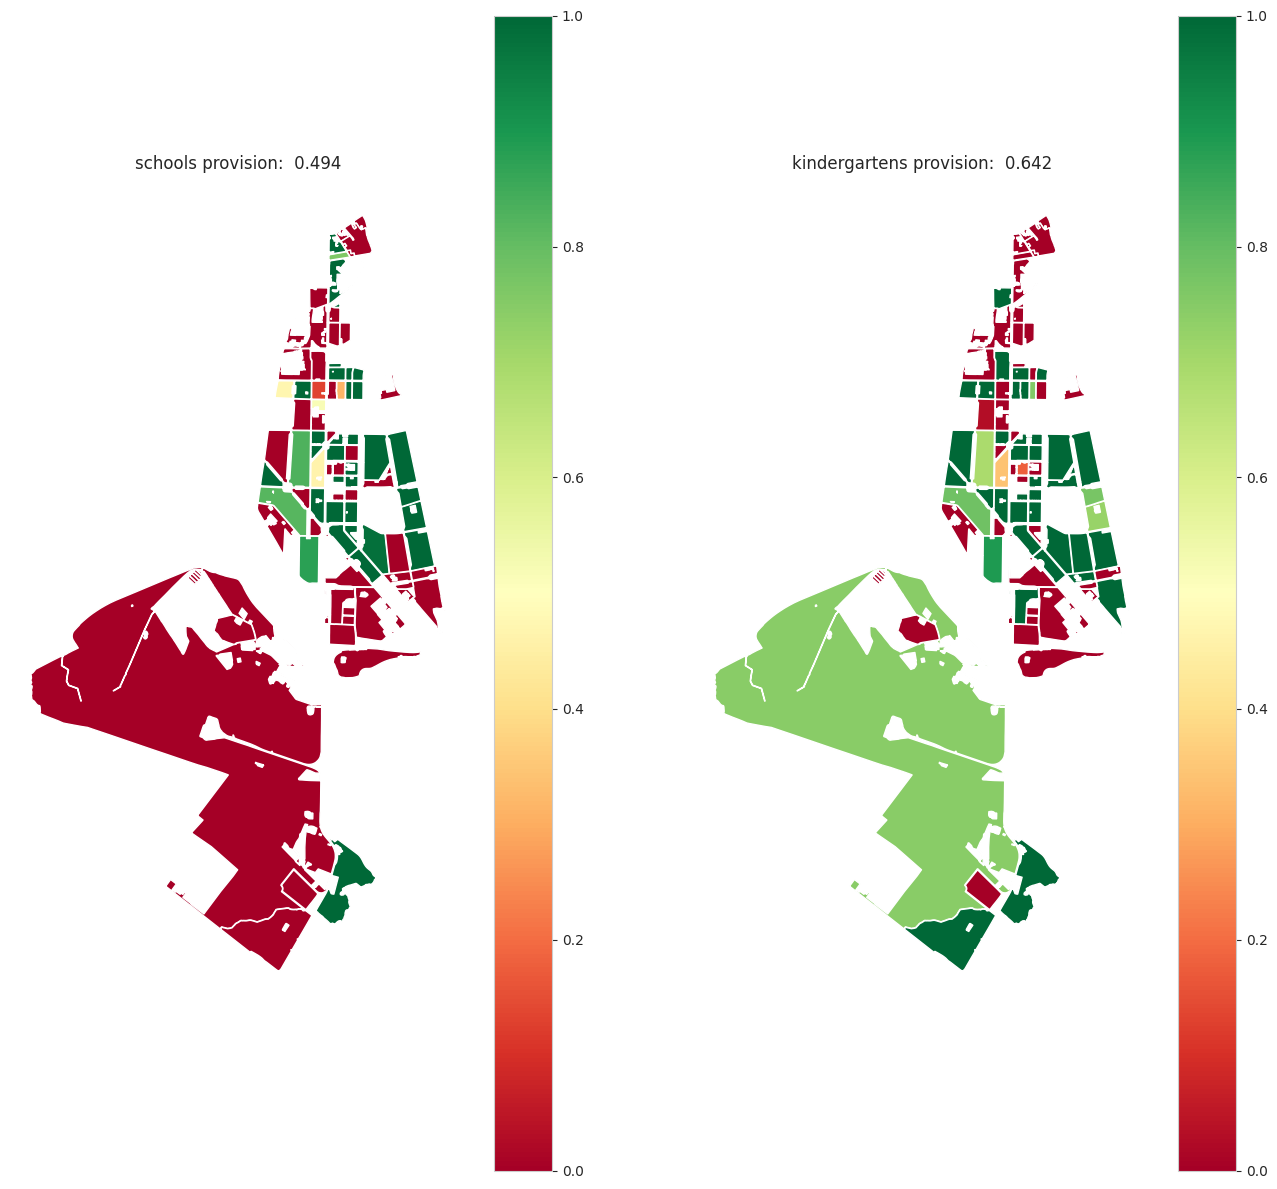

In [12]:
provisions_before = provision.calculate_provisions(['schools', 'kindergartens'])
Provision.plot_provisions(provisions_before)

In [13]:
update = {
  selected_block.id : {
    'population': 482+2040+1178+500+175,
    'kindergartens': 220,
    'schools': 1000
  }
} 
update_gdf = gpd.GeoDataFrame.from_dict(update, orient='index')

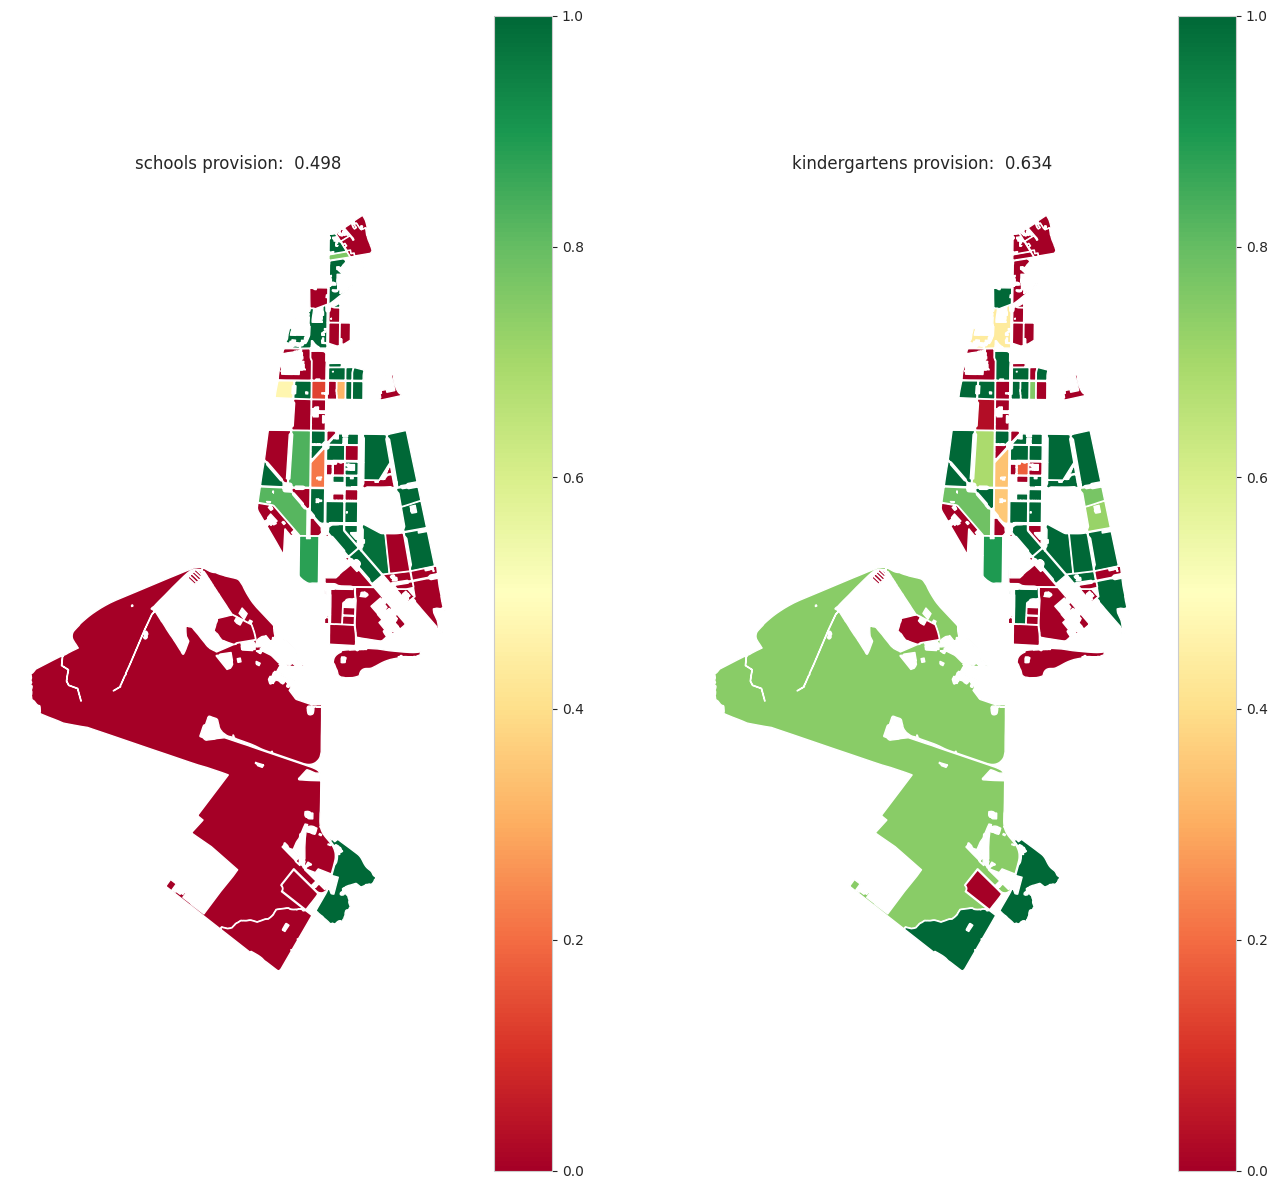

In [14]:
provisions_after = provision.calculate_provisions(['schools', 'kindergartens'], update_gdf)
Provision.plot_provisions(provisions_after)

In [15]:
for service_type in ['schools', 'kindergartens']:
  prov_before = Provision.total_provision(provisions_before[service_type])
  prov_after = Provision.total_provision(provisions_after[service_type])
  print(f"{prov_before} -> {prov_after}, delta = {prov_after-prov_before}")

0.49358197567434137 -> 0.498347639009027, delta = 0.004765663334685644
0.6422301618808169 -> 0.6344929810794315, delta = -0.007737180801385413


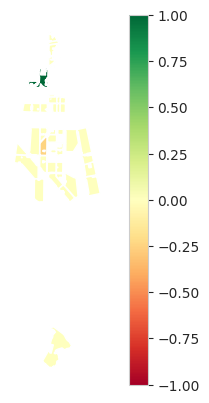

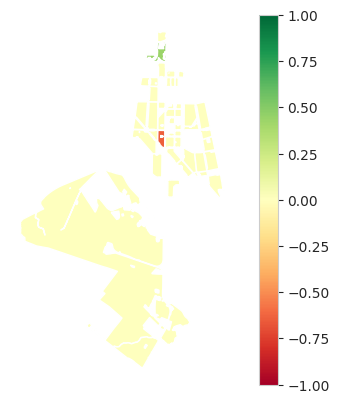

In [16]:
for service_type in ['schools', 'kindergartens']:
  prov_before = provisions_before[service_type]
  prov_after = provisions_after[service_type]
  Provision.plot_delta(prov_before, prov_after)

In [17]:
for service_type in ['schools', 'kindergartens']:
  before = provisions_before[service_type]['demand_within'].sum()
  after = provisions_after[service_type]['demand_within'].sum()
  print(f"{before} -> {after}, delta = {after-before}")

21995.0 -> 22469.0, delta = 474.0
14560.0 -> 14554.0, delta = -6.0
